In [1]:
import random

with open("seeds.txt", "w") as file:
    for i in range(5000):
        file.write(str(random.randint(0, 2**64)) + "\n")

# Load cubiomes data

In [2]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dataclasses import asdict
from typing import Literal
import json
import random

from data import World


def convert_cubiome_to_csv(cubiome_export_path, type: Literal["biomes", "structures"]):
    df = pd.read_csv(
        cubiome_export_path,
        header=6 if type == "biomes" else 5,
        sep=";",
    )

    return df


In [3]:
biomes = convert_cubiome_to_csv("biomes.txt", type="biomes")
structures = convert_cubiome_to_csv("structures.txt", type="structures")

In [4]:
ALL_BIOMES = biomes.columns[1:]
ALL_STRUCTURES = structures.structure.unique()
ALL_SEEDS = structures.seed.unique()

# Convert DataFrame representation to something easier to work with 

In [5]:
worlds = []

for seed in tqdm(ALL_SEEDS):
    world = World(seed)
    subs_structs = structures[structures["seed"] == seed]
    subs_biomes = biomes[biomes["seed"] == seed]

    if subs_biomes.empty or subs_structs.empty:
        continue
    for kind, count in subs_biomes.T.iloc[2:, :].itertuples():
        world.add_biome(kind, count)

    for _, _, kind, x, z, details in subs_structs.itertuples():
        world.add_structure(kind, x, z, details)

    worlds.append(world)

del biomes, structures

100%|██████████| 1773/1773 [01:24<00:00, 20.92it/s]


# Find best seed

For a seed $s_i \in S$, with $c_{ij}$ instances of a structure $t_j \in T$, the score is given by the sum of each structures Z-score. 

$$
    S = \{s_1, s_2, s_3, \dots, s_n\} \\
$$
$$
    T = \{t_1, t_2, t_3, \dots, t_m\} \\
$$
$$
    \text{score}\left(s_i\right) = \sum^m_{j=1} \hat{c}_{ij} \\ 
$$
$$
    \hat{c}_{ij} = \frac{c_{ij} - \mu_{j}}{\sigma_{j}} \\ 
$$

Where $\mu_j$ and $\sigma_j$ are the mean and variance in the count of structure $t_j$ across all world seeds. 

Therefore, the best seed $s^{*}$ is given by the world with the highest score. 

$$
s^{*} = \underset{i}{\text{arg~max}}~\text{score}\left(s_i\right)
$$

In [6]:
from scipy.stats import norm

dist = {}

for structure in tqdm(ALL_STRUCTURES):
    counts = []
    for world in worlds:
        counts.append(world.get_structure_count(structure))
    mean, std = norm.fit(counts)
    dist[structure] = dict(mean=mean, std=std)

100%|██████████| 20/20 [00:42<00:00,  2.15s/it]


In [7]:
def score(world, weights=None):
    score = 0
    for structure in ALL_STRUCTURES:
        if structure == "spawn":
            continue
        z = (world.get_structure_count(structure) - dist[structure]["mean"]) / dist[
            structure
        ]["std"]

        if weights is not None:
            z *= weights[structure]

        score += z

    return score


weights = {
    "mansion": 3,
    "spawn": 0,
    "swamp_hut": 2,
    "stronghold": 5,
    "jungle_pyramid": 0.1,
    "pillager_outpost": 0.1,
    "desert_pyramid": 0.1,
    "desert_well": 0.1,
    "igloo": 0.5,
    "ancient_city": 5,
    "trail_ruins": 0.1,
    "monument": 2,
    "village": 2,
    "buried_treasure": 0.1,
    "shipwreck": 0.1,
    "ruined_portal": 0.1,
    "ocean_ruin": 0.1,
    "trial_chambers": 2,
    "mineshaft": 0.1,
    "amethyst_geode": 0.1,
}
scores = {world.seed: score(world, weights) for world in worlds}
scores = dict(sorted(scores.items(), key=lambda x: x[1]))

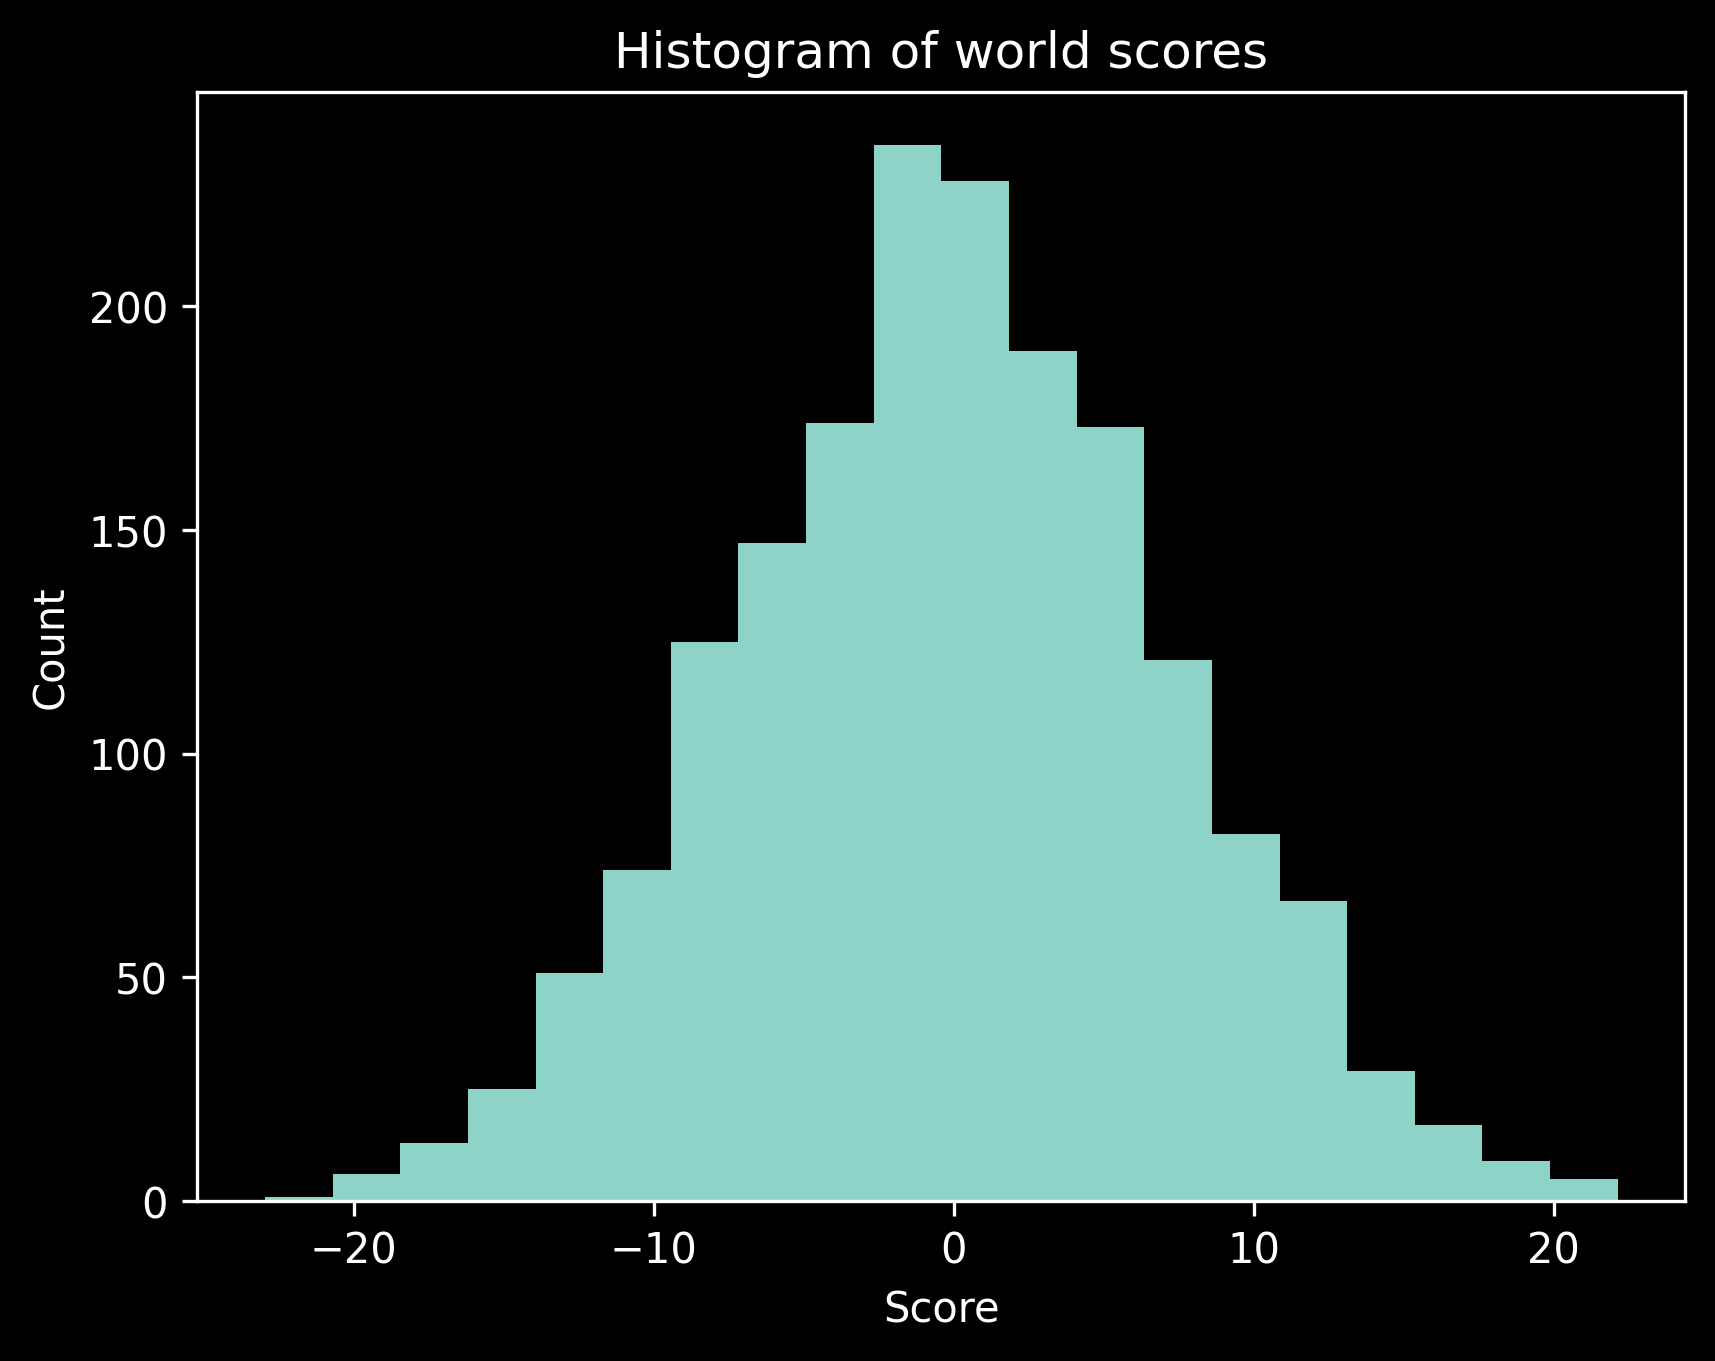

In [8]:
plt.figure(dpi=300)
plt.title("Histogram of world scores")
plt.hist(list(scores.values()), bins=20, stacked=False)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [9]:
best_seed = list(scores.keys())[-1]
best_world = [world for world in worlds if world.seed == best_seed][0]

In [10]:
spawn = list(filter(lambda s: s.kind == "spawn", best_world.structures))[0]

In [11]:
best_seed

9222393708229838271

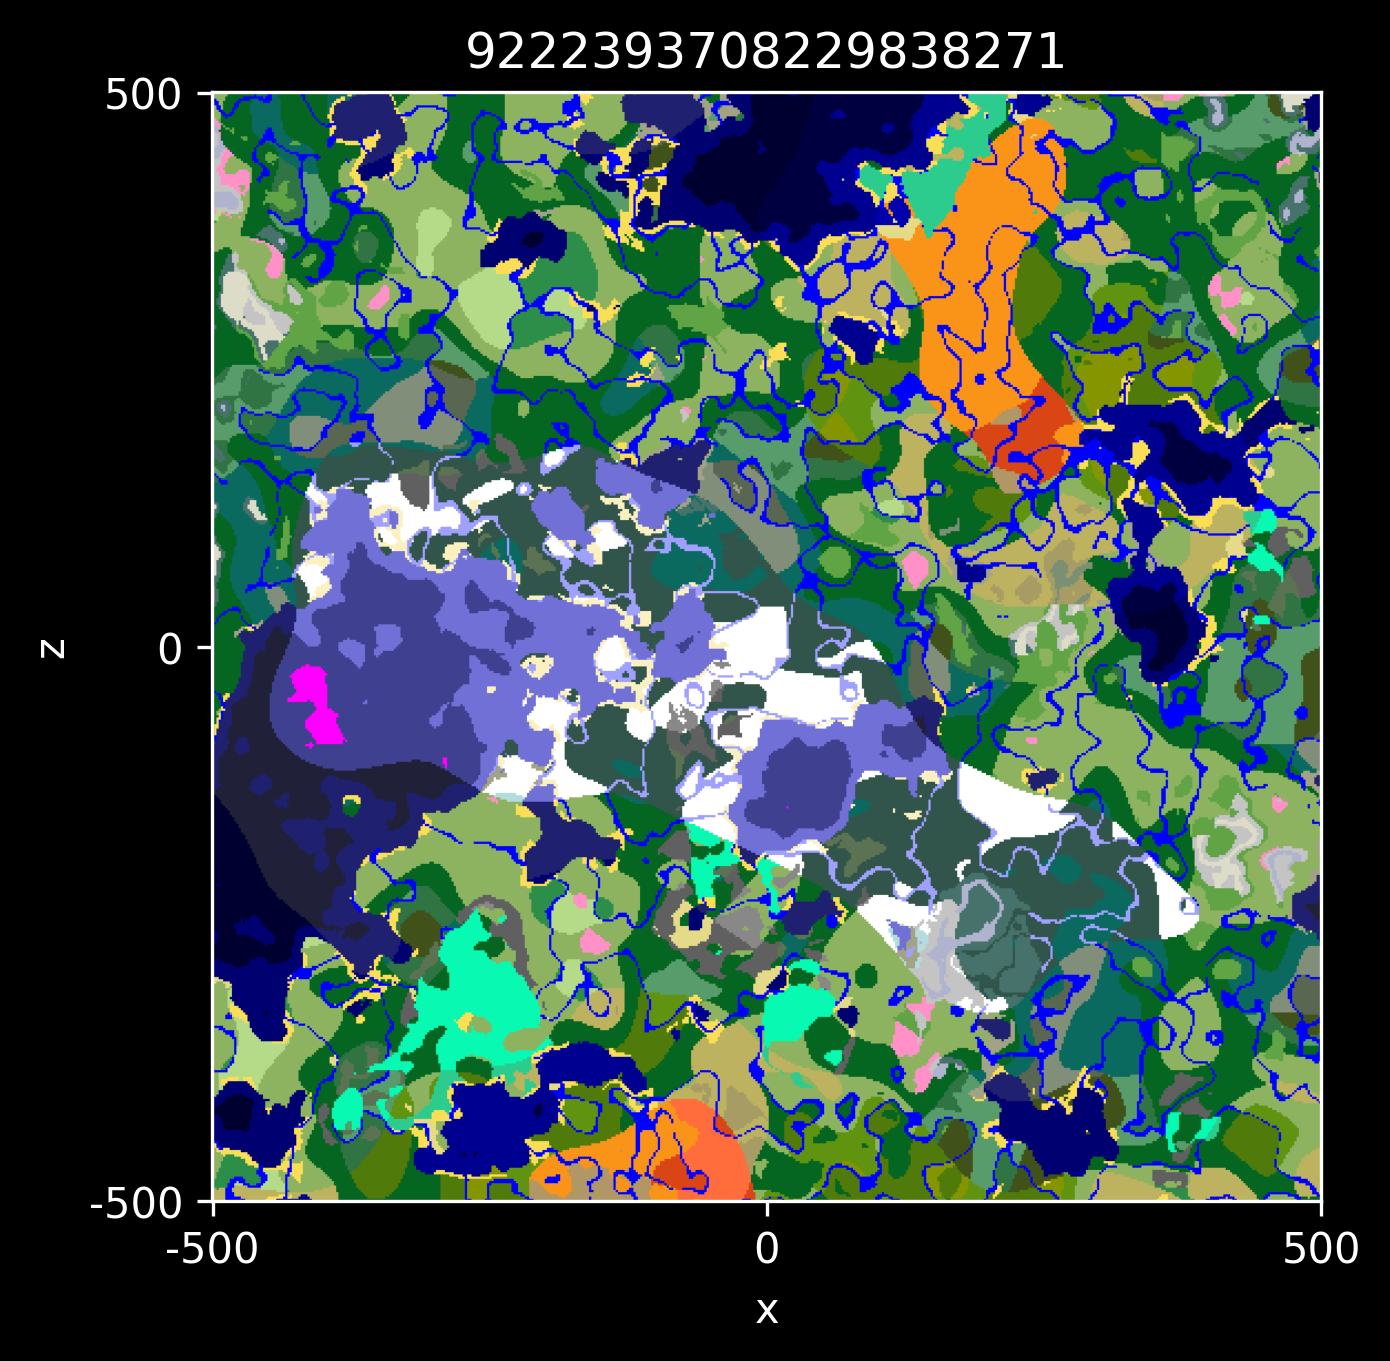

In [16]:
img = best_world.generate_image()

plt.figure(dpi=300)
plt.title(best_world.seed)
plt.imshow(img)
plt.xticks([0, 1000, 2000], [-500, 0, 500])
plt.xlabel("x")
plt.yticks([0, 1000, 2000], [500, 0, -500])
plt.ylabel("z")
plt.show()

In [13]:
df = {"structure": [], "count": [], "z-score": [], "weighted-score": []}
for structure in ALL_STRUCTURES:
    if structure == "spawn":
        continue

    df["structure"].append(structure)
    df["count"].append(best_world.get_structure_count(structure))
    df["z-score"].append(
        (df["count"][-1] - dist[structure]["mean"]) / dist[structure]["std"]
    )
    df["weighted-score"].append(df["z-score"][-1] * weights[structure])

df = pd.DataFrame(df).sort_values("z-score", ascending=False)
df

structure  count   z-score  weighted-score
8       ancient_city     46  2.695428       13.477139
0            mansion      4  2.419513        7.258539
17         mineshaft   1692  2.389804        0.238980
9        trail_ruins     53  1.820136        0.182014
2         stronghold      8  1.466586        7.332930
14     ruined_portal    248  0.817929        0.081793
7              igloo     27  0.609346        0.304673
11           village     87  0.483718        0.967435
3     jungle_pyramid     11  0.452027        0.045203
5     desert_pyramid      9  0.269825        0.026982
18    amethyst_geode  16305  0.212378        0.021238
6        desert_well     11  0.034164        0.003416
10          monument     35 -0.086741       -0.173482
1          swamp_hut      3 -0.451897       -0.903794
4   pillager_outpost     10 -0.796294       -0.079629
12   buried_treasure     84 -1.188924       -0.118892
15        ocean_ruin    209 -1.774935       -0.177494
13         shipwreck    148 -2.180978       -0.218098
16    trial_chambers    304 -3.068879       -6.137758

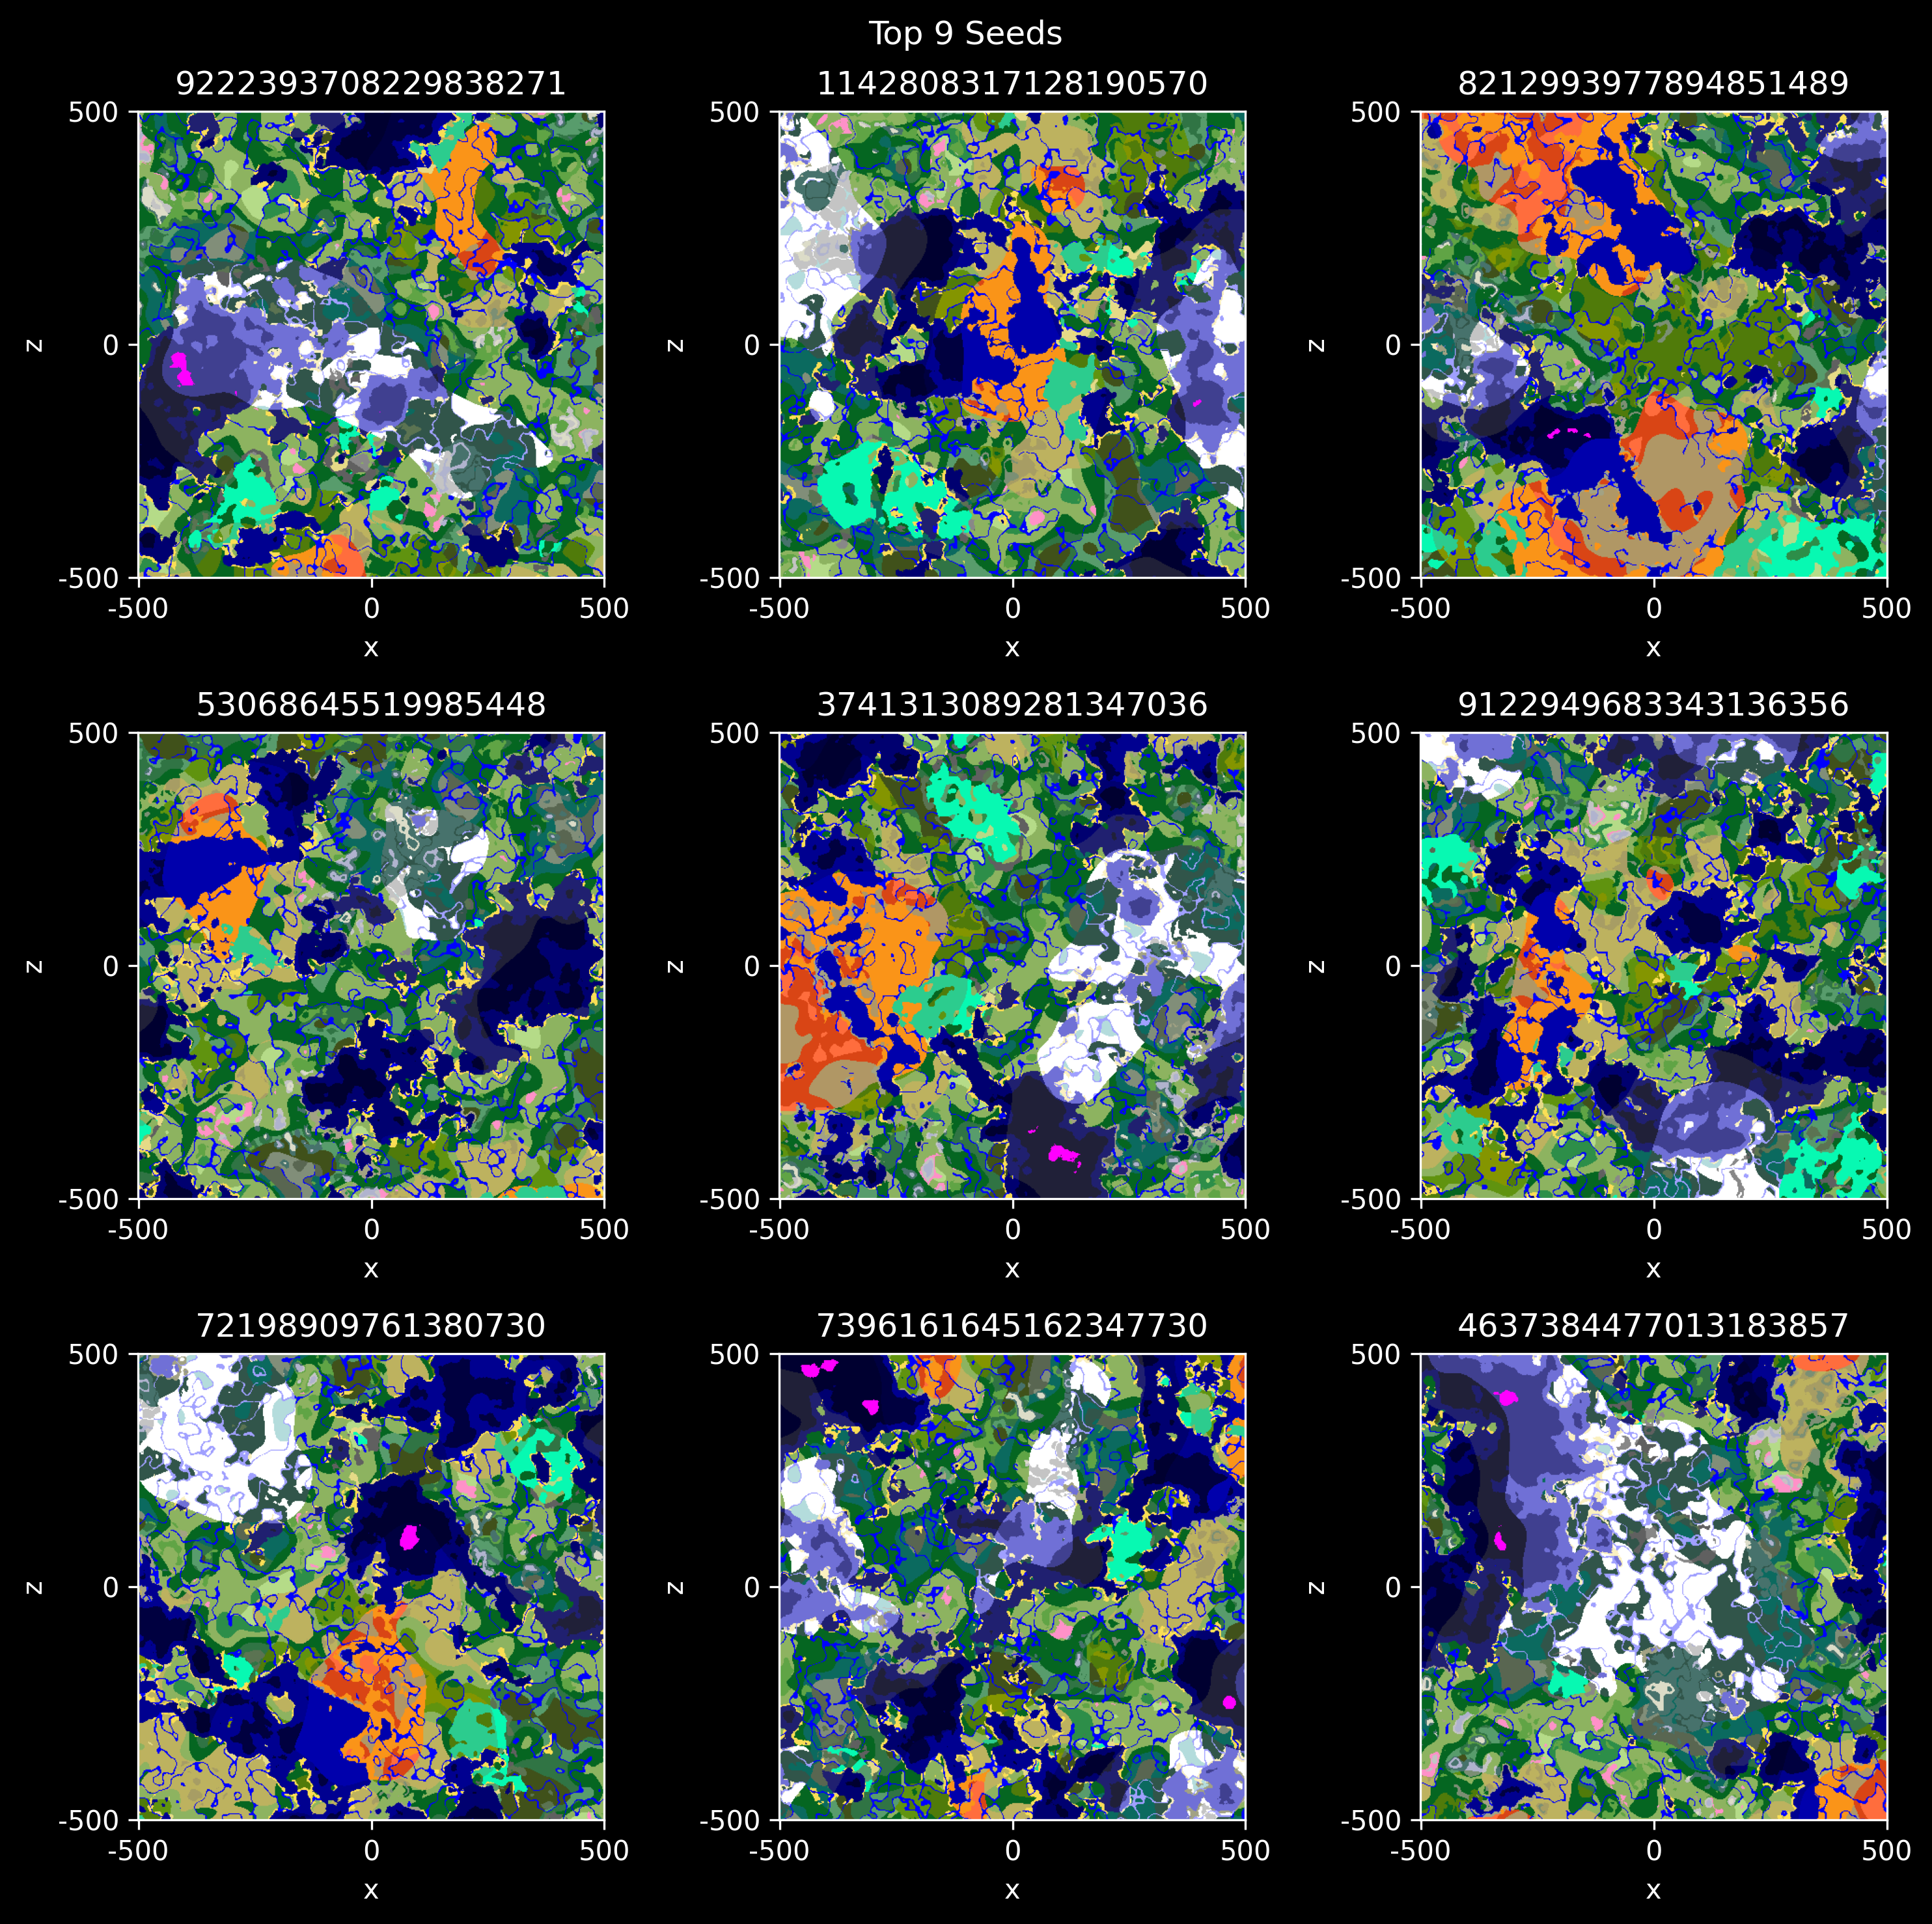

In [15]:
fig, axs = plt.subplots(3, 3, dpi=300, figsize=(10, 10))
fig.suptitle("Top 9 Seeds")
fig.set_tight_layout(True)

for i, (ax, seed) in enumerate(zip(axs.flatten(), reversed(scores.keys()))):
    world = [world for world in worlds if world.seed == seed][0]
    ax.title.set_text(seed)
    ax.imshow(world.generate_image())
    ax.set_xticks([0, 1000, 2000], [-500, 0, 500])
    ax.set_xlabel("x")
    ax.set_yticks([0, 1000, 2000], [500, 0, -500])
    ax.set_ylabel("z")
plt.show()